In [1]:
import os
import sys
import pandas as pd
#import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath(os.path.join('..', 'src'))
print(module_path)
# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
# Now you can import the desired function or class
from graph_helpers import *
from helpers import *
from mod_si import *
from plots import *
from find_net_stats import *

/nfs/nfs9/home/nobackup/vakrao/nz_model/src
/nfs/nfs9/home/nobackup/vakrao/nz_model/src


In [2]:
## all relevant file types 
#year_log,year_lin = "../src/E0/E0_log_Y_check.csv","../src/E0/E0_linear.csv"
year_log,year_lin = "../src/Y_C/Y_C_log_Y_D.csv","../src/Y_C/Y_C_lin_Y_D.csv"
month_log,month_lin = "../src/M_C/M_C_log_M_D.csv","../src/M_C/M_C_lin_M_D.csv"
seas_log,seas_lin = "../src/S_C/S_C_log_S_D.csv","../src/S_C/S_C_lin_S_D.csv"
real_inc_fp,window_inc_fp  = "../params/new_psa.csv","../params/window_psa.csv"
post_fp = "static_post.csv"
params = "lin"
calib_shift = False
# R determines RMSE threshold 
R = .01

In [3]:
ylin = pd.read_csv(year_lin)
slin = pd.read_csv(seas_lin)
mlin = pd.read_csv(month_lin)

In [4]:
all_configs = len(set(ylin["b_b"]))*len(set(ylin["b_w"]))*len(set(ylin["D"]))*len(set(ylin["seed"]))

In [5]:
all_eps = [10,20,30,40,50,60,70,80,90,100]
pct = [i/100 for i in range(10,150,10)]
all_vals = []
agg = "S"
in_range_s = num_fitting(slin,real_inc_fp,agg,all_eps,pct)
in_range_m = num_fitting(mlin,real_inc_fp,agg,all_eps,pct)
in_range_y = num_fitting(ylin,real_inc_fp,agg,all_eps,pct)

IOStream.flush timed out


In [6]:
min_val = 100
for k in in_range_s:
    s_val = in_range_s[k]
    m_val = in_range_m[k]
    y_val = in_range_y[k]
    if s_val > min_val and y_val > min_val and m_val > min_val:
        print(k)
        print(in_range_s[k])
        print(in_range_m[k])
        print(in_range_y[k])
        break

(30, 0.8)
1133
1827
1689


In [7]:
proper_s,proper_m,proper_y = {},{},{}
for k in in_range_s:
    proper_s[k] = (in_range_s[k] / all_configs)*100
    proper_m[k] = (in_range_m[k] / all_configs)*100
    proper_y[k] = (in_range_y[k] / all_configs)*100
    #proper_s[k] = (in_range_s[k])
    #proper_m[k] = (in_range_m[k])
    #proper_y[k] = (in_range_y[k])

In [8]:
all_data = {"m":proper_m,"s":proper_s,"y":proper_y}

In [9]:
all_hdf = []
for a in all_data:
    dat = all_data[a]
    s_df = pd.DataFrame(
    [(eps, x, val) for (eps, x), val in dat.items()],
    columns=["epsilon", "x_value", "value"]
    )

    s_df = s_df[s_df["x_value"] <= 1.0]
    
    heatmap_df = s_df.pivot(
        index="x_value",
        columns="epsilon",
        values="value"
    )
    
    heatmap_df = heatmap_df.sort_index().sort_index(axis=1)
    all_hdf.append(heatmap_df)

In [10]:
agg_colors = {
    "Yearly":   "tab:blue",
    "Seasonal": "tab:orange",
    "Monthly":  "tab:green",
}

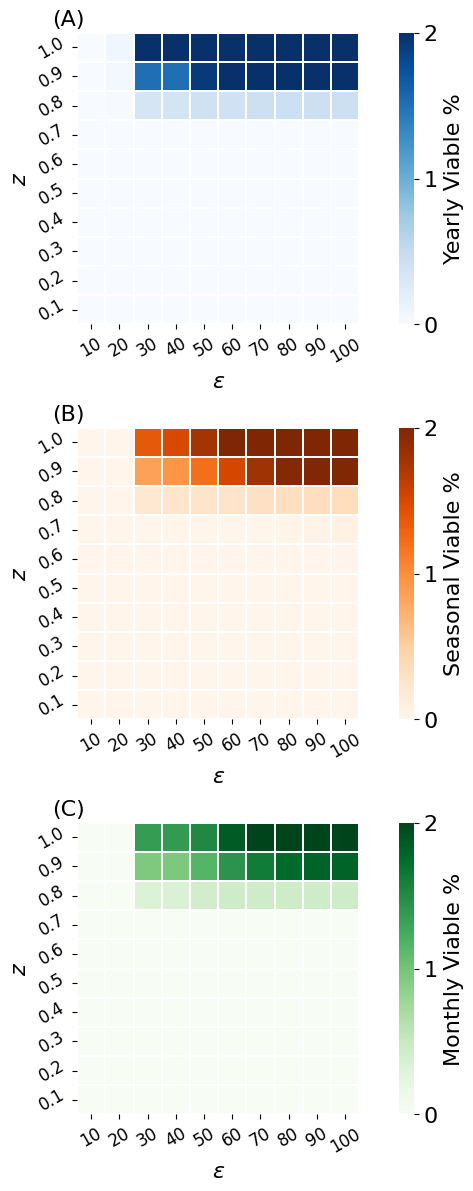

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(5, 12), sharey=True)

cmaps = ["Blues", "Oranges", "Greens"]
row_titles = ["Yearly", "Seasonal", "Monthly"]
cbar_fs = 16
tick_fs = 16
for i, (h, cmap, title) in enumerate(zip(all_hdf, cmaps, row_titles)):
    cbar_text = title + " Viable %"
    k = sns.heatmap(
        h,
        ax=axs[i],
        cmap=cmap,
        vmin=0.0,
        vmax=2.0,                 # <-- 0–5%
        linewidths=0.3,
        cbar=True,
        cbar_kws={
            "label": cbar_text,
            "fraction": 0.2,
            "pad": 0.1,
            "ticks": [0, 1, 2, 3]
        }
    )
    k.collections[0].colorbar.ax.yaxis.label.set_size(cbar_fs)
    k.collections[0].colorbar.ax.tick_params(labelsize=tick_fs)
    axs[i].tick_params(rotation=30,labelsize=12)
    axs[i].set_xlabel(f"$\epsilon$",fontsize=16)
    axs[i].set_ylabel(f"$z$",fontsize=16)
    axs[i].invert_yaxis()
    #axs[i].set_title(title, loc="center", fontsize=11, fontweight="bold")

panel_labels = ['(A)', '(B)', '(C)']
label_fs = 16  # adjust if needed

k = 0
for i in range(3):
    ax = axs[i]
    ax.text(
        -0.09, 1.08,            # position relative to axis
        panel_labels[k],
        transform=ax.transAxes,
        fontsize=label_fs,
        #fontweight='bold',
        va='top',
        ha='left'
    )
    k += 1
plt.tight_layout()
plt.savefig("figs/s_choice.png", dpi=300)
plt.show()